# "*Simpson's paradox in Covid-19 case fatality rates: a mediation analysis of age-related causal effects*"

This interactive notebook accompanies the paper "*Simpson's paradox in Covid-19 case fatality rates: a mediation analysis of age-related causal effects*".
It contains the curated dataset (also attached in .csv form) and code to reproduce all our analyses and figures (incl. appendix), following the structure of the paper.

We include the most important definitions and formulas, as well as a few descriptions and comments to guide the reader; please refer to the main paper for details.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rc
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 0) Data

### Covid19Dataset `class`
In order to curate CFR data reported from different countries in a coherent format, we use the following `Covid19Dataset` class which requires at least a specification of the following information to create an instance:


*   country of reporting
*   date of reporting
*   absolute number of *confirmed* cases, separated into age groups (0-9, 10-19, etc)
*   absolute number of *confirmed* fatalities, separated into age groups (0-9, 10-19, etc)
*   a reliable source (in the form of a dictionary), generally either reports from a country's health ministry or a scientific publication


[Note of caution: numbers of confirmed cases and fatalities likely do not relfect the true numbers; additionally, relying on *confirmed* cases may introduce selection bias due to different approaches to testing, see the discussion section of our paper for further details.]

In [2]:
class Covid19Dataset():
    """
    A class for datasets with case and fatality numbers stratified by age 
    group for different countries.
    """
    def __init__(self,
                country,
                date,
                confirmed_cases,
                fatalities,
                source,
                comments=None,
                age_ranges=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
                ):
        self.country = country
        self.date = date
        self.confirmed_cases = np.array(confirmed_cases)
        self.fatalities = np.array(fatalities)
        self.source = source
        self.comments = comments
        self.age_ranges = age_ranges
        
        # compute quantities of interest
        self.cfr = self.fatalities/ self.confirmed_cases
        self.total_cases = sum(self.confirmed_cases)
        self.total_fatalities = sum(self.fatalities)
        self.case_rates_by_age = self.confirmed_cases/self.total_cases
        self.total_cfr = sum(self.case_rates_by_age * self.cfr)

## Argentina

### 28 May

In [3]:
Argentina_May28 = Covid19Dataset(
    country = 'Argentina',
    date = '28 May', 
    confirmed_cases = [1002, 1080, 2813, 3142, 2508, 1812, 1005, 651, 662],
    fatalities = [0, 1, 1, 9, 24, 54, 101, 123, 194],
    source = {
        'type': 'official ministry report',
        'author': 'Ministry of Health of Argentina',
        'date': '28 May 2020',
        'url': 'https://www.argentina.gob.ar/salud/coronavirus-COVID-19/sala-situacion'  # accessed 29 May
        }
)

## China

### 17 February 2020

In [4]:
China_Feb17 = Covid19Dataset(
    country = 'China',
    date = '17 February', 
    confirmed_cases = [416, 549, 3619, 7600, 8571, 10008, 8583, 3918, 1408],
    fatalities = [0, 1, 7, 18, 38, 130, 309, 312, 208],
    source = {
        'type': 'scientific publication',
        'title': 'Characteristics of and important lessons from the coronavirus\
            disease 2019 (COVID-19) outbreak in China: summary of a report of\
            72 314 cases from the Chinese Center for Disease Control and Prevention',
        'author': 'Wu, Zunyou and McGoogan, Jennifer M',
        'journal': 'Jama',
        'date': '24 February 2020',
        'url': 'https://jamanetwork.com/journals/jama/fullarticle/2762130'
        }
)

## Colombia

### 28 May

In [5]:
Colombia_May28 = Covid19Dataset(
    country = 'Colombia',
    date = '28 May', 
    confirmed_cases = [1105, 1950, 5614, 5615, 4033, 3286, 1961, 1117, 685],
    fatalities = [5, 1, 13, 24, 61, 121, 192, 214, 191],
    source = {
        'type': 'official report of the government',
        'date': '28 May 2020, 7:30 pm',
        'author': 'Instituto Nacional de Salud',
        'url': 'https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx'
        }
)

## Diamond Princess (cruise ship)

### 26 March

In [6]:
DiamondPrincess_Mar26 = Covid19Dataset(
    country = 'Diam. Princ.',
    date = '26 March', 
    confirmed_cases = [1, 5, 28, 34, 27, 59, 177, 234, 54],
    fatalities = [0, 0, 0, 0, 0, 0, 0, 3, 4],
    source = {
        'type': 'scientific publication',
        'title': 'Estimating the infection and case fatality ratio for coronavirus disease (COVID-19) using age-adjusted data from the outbreak on the Diamond Princess cruise ship, February 2020',
        'journal': 'Eurosurveillance',
        'date': '26 March 2020',
        'url': 'https://pubmed.ncbi.nlm.nih.gov/32234121/'
        }
)

## Italy

### 9 March 2020

In [7]:
Italy_Mar9 = Covid19Dataset(
    country = 'Italy',
    date = '9 March', 
    confirmed_cases = [43, 85, 296, 470, 891, 1453, 1471, 1785, 1532],
    fatalities = [0, 0, 0, 0, 1, 3, 37, 114, 202],
    source = {
        'type': 'official report',
        'date': '9 March 2020, 4pm',
        'author': 'Istituto Superiore di Sanità \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-\sorveglianza-integrata-COVID-19_09-marzo-2020.pdf'
        }
)

### 12 March 2020

In [8]:
Italy_Mar12 = Covid19Dataset(
    country = 'Italy',
    date = '12 March', 
    confirmed_cases = [63,	118,	511,	819,	1523,	2480,	2421,	2849,	2533],
    fatalities = [0,	0,	0,	1,	1,	14,	65,	274, 430],
    source = {
        'type': 'official report',
        'date': '12 March 2020, 4pm',
        'author': 'Istituto Superiore di Sanità \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_12-marzo-2020.pdf'
        },
    comments = '565 cases with unknown age ("non nota") were discarded \
       from the data (4.1% of all cases)'
)

### 19 March 2020

In [9]:
Italy_Mar19 = Covid19Dataset(
    country = 'Italy',
    date = '19 March', 
    confirmed_cases = [205,	270,	1374,	2525,	4396,	6834,	6337,	7121,	6467],
    fatalities = [0,	0,	0,	9,	25,	83,	312,	1090,	1528],
    source = {
        'type': 'official report',
        'date': '19 March 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.iss.it/documents/20126/0/Bollettino+sorveglianza+integrata+COVID-19_19+marzo+2020.pdf/'
    },
    comments = '202 cases with unknown age ("non nota") were discarded \
        from the data (0.6% of all cases)'
)

### 23 March 2020

In [10]:
Italy_Mar23 = Covid19Dataset(
    country = 'Italy',
    date = '23 March', 
    confirmed_cases = [318, 386, 2192, 3995, 7267, 11280, 10423, 11320, 10514],
    fatalities = [0,	0,	0,	12, 41, 168, 541, 1768, 2488],
    source = {
        'type': 'official report',
        'date': '23 March 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_23-marzo%202020.pdf'
    },
    comments = '294 cases with unknown age ("non nota") were discarded \
        from the data (0.5% of all cases)'
)

### 26 March 2020

In [11]:
Italy_Mar26 = Covid19Dataset(
    country = 'Italy',
    date = '26 March', 
    confirmed_cases = [428, 512, 2778, 5033, 9295, 14508,13243, 14198, 13539],
    fatalities = [0,	0,	0,	17, 67, 243, 761, 2403, 3310],
    source = {
        'type': 'official report',
        'date': '26 March 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-marzo%202020.pdf'
    },
    comments = '246 cases with unknown age ("non nota") were discarded \
        from the data (0.3% of all cases)'
)


### 2 April 2020

In [12]:
Italy_Apr2 = Covid19Dataset(
    country = 'Italy',
    date = '2 April', 
    confirmed_cases = [693, 931, 4530, 7466, 13701, 20975, 18089, 19238, 20608],
    fatalities = [0, 0, 6, 29, 110, 479, 1448, 4196, 6280],
    source = {
        'type': 'official report',
        'date': '2 April 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_2-aprile-2020.pdf'
    },
    comments = '168 cases with unknown age ("non nota") were discarded \
        from the data (0.2% of all cases)'
)

### 9 April 2020

In [13]:
Italy_Apr9 = Covid19Dataset(
    country = 'Italy',
    date = '9 April', 
    confirmed_cases = [938, 1432, 6360, 9956, 17745, 26391, 21734, 22934, 28478],
    fatalities = [1, 0, 7, 36, 153, 638, 1957, 5366, 8495],
    source = {
        'type': 'official report',
        'date': '9 April 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_9-aprile-2020.pdf'
    },
    comments = '142 cases with unknown age ("non nota") were discarded \
        from the data (0.1% of all cases)'
)

### 16 April 2020

In [14]:
Italy_Apr16 = Covid19Dataset(
    country = 'Italy',
    date = '16 April', 
    confirmed_cases = [1123, 1804, 7737, 11686, 20519, 29858, 24040, 25717, 36519],
    fatalities = [1, 0, 7, 40, 178, 756, 2284, 6203, 10525],
    source = {
        'type': 'official report',
        'date': '16 April 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_16-aprile-2020.pdf'
    },
    comments = '104 cases with unknown age ("non nota") were discarded \
        from the data (0.1% of all cases)'
)

### 23 April 2020

In [15]:
Italy_Apr23 = Covid19Dataset(
    country = 'Italy',
    date = '23 April', 
    confirmed_cases = [1304, 2146, 8963, 13137, 22767, 32524, 25707, 27615, 42862],
    fatalities = [2, 0, 7, 48, 203, 861, 2576, 6882, 12609],
    source = {
        'type': 'official report',
        'date': '23 April 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_23-aprile-2020.pdf'
    },
    comments = '118 cases with unknown age ("non nota") were discarded \
        from the data (0.1% of all cases)'
)

### 28 April 2020

In [16]:
Italy_Apr28 = Covid19Dataset(
    country = 'Italy',
    date = '28 April', 
    confirmed_cases = [1478, 2511, 10377, 14907, 25644, 35986, 27880, 30158, 50448],
    fatalities = [2, 0, 8, 49, 224, 918, 2727, 7291, 13996],
    source = {
        'type': 'official report',
        'date': '28 April 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_28-aprile-2020.pdf'
    },
    comments = '81 cases with unknown age ("non nota") were discarded \
        from the data (<0.1% of all cases)'
)

### 7 May 2020

In [17]:
Italy_May7 = Covid19Dataset(
    country = 'Italy',
    date = '7 May', 
    confirmed_cases = [1642, 2908, 11457, 16189, 27553, 38399, 29252, 31627, 55020],
    fatalities = [3, 0, 9, 54, 246, 993, 2976, 7849, 15825],
    source = {
        'type': 'official report',
        'date': ' 7 May 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_7-maggio-2020.pdf'
    },
    comments = '56 cases with unknown age ("non nota") were discarded \
        from the data (<0.1% of all cases)'
)

### 14 May 2020

In [18]:
Italy_May14 = Covid19Dataset(
    country = 'Italy',
    date = '14 May', 
    confirmed_cases = [1774, 3148, 12115, 16981, 28627, 39822, 30010, 32353, 57192],
    fatalities = [3, 0, 12, 59, 258, 1063, 3127, 8221, 16948],
    source = {
        'type': 'official report',
        'date': ' 14 May 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_14-maggio-2020.pdf'
    },
    comments = '52 cases with unknown age ("non nota") were discarded \
        from the data (<0.1% of all cases)'
)

### 20 May 2020

In [19]:
Italy_May20 = Covid19Dataset(
    country = 'Italy',
    date = '20 May', 
    confirmed_cases = [1851, 3312, 12599, 17528, 29390, 40803, 30466, 32824, 58380],
    fatalities = [4, 0, 14, 61, 268, 1101, 3219, 8447, 17903],
    source = {
        'type': 'official report',
        'date': ' 20 May 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_20-maggio-2020.pdf'
    },
    comments = '51 cases with unknown age ("non nota") were discarded \
        from the data (<0.1% of all cases)'
)

### 26 May 2020

In [20]:
Italy_May26 = Covid19Dataset(
    country = 'Italy',
    date = '26 May', 
    confirmed_cases = [1919, 3442, 12933, 17934, 29942, 41435, 30880, 33141, 59134],
    fatalities = [4, 0, 12, 62, 273, 1109, 3259, 8562, 18395],
    source = {
        'type': 'official report',
        'date': ' 26 May 2020, 4pm',
        'author': 'Istituto Superiore di Sanità  \
            (ISS, Italian National Institute of Health)',
        'url': 'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-maggio-2020.pdf'
    },
    comments = '51 cases with unknown age ("non nota") were discarded \
        from the data (<0.1% of all cases)'
)

## Netherlands


### 28 May 2020

In [21]:
Netherlands_28May = Covid19Dataset(
    country = 'Netherlands',
    date = '28 May', 
    confirmed_cases = [128, 587, 4336, 4093, 5269, 8437, 5949, 6229, 10919],
    fatalities = [0, 1, 3, 10, 28, 142, 484, 1596, 3639],
    source = {
        'type': 'official report',
        'date': ' 28 May 2020',
        'author': 'Rijksinstituut voor Volksgezondheid en Milieu',
        'url': 'https://www.rivm.nl/documenten/epidemiologische-situatie-covid-19-in-nederland-28-mei-2020'
    }
)

## Portugal

### 28 May 2020

In [22]:
Portugal_28May = Covid19Dataset(
    country = 'Portugal',
    date = '28 May', 
    confirmed_cases = [626, 1052, 4114, 4736, 5315, 5253, 3484, 2537, 4479],
    fatalities = [0, 0, 1, 1, 15, 42, 122, 269, 919],
    source = {
        'type': 'official report',
        'date': '28 May 2020 (data from 27 May 24:00)',
        'author': 'Servico Nacional de Saude Republica Portuguesa',
        'url': 'https://covid19.min-saude.pt/wp-content/uploads/2020/05/87_DGS_boletim_20200528.pdf'
    }
)

## South Africa

### 28 May 2020

In [23]:
SouthAfrica_28May = Covid19Dataset(
    country = 'South Africa',
    date = '28 May', 
    confirmed_cases = [755, 1147, 5319, 7720, 5754, 3753, 1663, 754, 415],
    fatalities = [2, 1, 4, 33, 61, 144, 153, 113, 66],
    source = {
        'type': 'official report',
        'date': '28 May 2020 (data from 27 May 24:00)',
        'author': 'Health Department republic of South Africa',
        'url': 'https://sacoronavirus.co.za/2020/05/29/update-on-covid-19-28th-may-2020/' # accessed 29 May 2:00 am CEST
    }
)

## Spain

### 22 March 2020 

In [24]:
Spain_Mar22 = Covid19Dataset(
    country = 'Spain',
    date = '22 March', 
    confirmed_cases = [129,	221, 1285, 2208, 2919, 3129, 2916, 3132, 3020],
    fatalities = [0, 1, 4, 3, 9, 20, 63, 164, 541],
    source = {
        'type': 'official ministry report',
        'date': '22 March 2020 (data from 21 March, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_52_COVID-19.pdf'
    },
)

### 26 March 2020 

In [25]:
Spain_Mar26 = Covid19Dataset(
    country = 'Spain',
    date = '26 March', 
    confirmed_cases = [175,	302, 1932, 3454, 5045, 5749, 5397, 5377, 5385],
    fatalities = [0, 1, 4, 7, 19, 35, 114, 303, 843],
    source = {
        'type': 'official ministry report',
        'date': '26 March 2020 (data from 25 March, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_56_COVID-19.pdf'
    },
)

### 30 March 2020

In [26]:
Spain_Mar30 = Covid19Dataset(
    country = 'Spain',
    date = '30 March', 
    confirmed_cases = [212, 368, 2883, 5351, 7965, 9390, 8744, 8625, 8088],
    fatalities = [0, 1, 6, 10, 36, 78, 232, 759, 1662],
    source = {
        'type': 'official ministry report',
        'date': '30 March 2020 (data from 29 March, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_60_COVID-19.pdf'
    },
)

### 2 April 2020

In [27]:
Spain_Apr2 = Covid19Dataset(
    country = 'Spain',
    date = '2 April', 
    confirmed_cases = [250, 434, 3590, 6853, 10551, 12722, 11657, 11368, 11752],
    fatalities = [0, 1, 6, 18, 49, 131, 373, 1176, 2607],
    source = {
        'type': 'official ministry report',
        'date': '2 April 2020 (data from 1 April, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_63_COVID-19.pdf'
    },
)

### 9 April 2020

In [28]:
Spain_Apr9 = Covid19Dataset(
    country = 'Spain',
    date = '9 April', 
    confirmed_cases = [285, 588, 5381, 10341, 16088, 19836, 17713, 16957, 19258],
    fatalities = [1, 1, 11, 24, 61, 197, 597, 1773, 4064],
    source = {
        'type': 'official ministry report',
        'date': '9 April 2020 (data from 8 April, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_70_COVID-19.pdf'
    },
)

### 16 April 2020

In [29]:
Spain_Apr16 = Covid19Dataset(
    country = 'Spain',
    date = '16 April', 
    confirmed_cases = [423, 734, 6763, 12466, 19536, 24471, 21249, 20287, 27153],
    fatalities = [1, 2, 19, 37, 116, 312, 958, 2868, 6480],
    source = {
        'type': 'official ministry report',
        'date': '16 April 2020 (data from 15 April, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_77_COVID-19.pdf'
    },
)

### 23 April 2020

In [30]:
Spain_Apr23 = Covid19Dataset(
    country = 'Spain',
    date = '23 April', 
    confirmed_cases = [502, 869, 7962, 14304, 22430, 27795, 23595, 22470, 32760],
    fatalities = [2, 3, 25, 50, 138, 400, 1149, 3374, 7937],
    source = {
        'type': 'official ministry report',
        'date': '23 April 2020 (data from 22 April, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_84_COVID-19.pdf'
    },
)

### 28 April 2020

In [31]:
Spain_Apr28 = Covid19Dataset(
    country = 'Spain',
    date = '28 April', 
    confirmed_cases = [660, 1206, 11138, 18924, 29629, 36423, 30361, 29550, 46975],
    fatalities = [2, 4, 22, 55, 172, 497, 1387, 4012, 9702],
    source = {
        'type': 'official ministry report',
        'date': '28 April 2020 (data from 27 April, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_89_COVID-19.pdf'
    },
)

### 7 May 2020

In [32]:
Spain_May7 = Covid19Dataset(
    country = 'Spain',
    date = '7 May', 
    confirmed_cases = [765, 1398, 12321, 20759, 32239, 39418, 32226, 30861, 50457],
    fatalities = [2, 5, 21, 57, 185, 569, 1541, 4320, 10760],
    source = {
        'type': 'official ministry report',
        'date': '7 May 2020 (data from 6 May, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_98_COVID-19.pdf'
    },
)

### 14 May 2020

In [33]:
Spain_May14 = Covid19Dataset(
    country = 'Spain',
    date = '14 May', 
    confirmed_cases = [871, 1619, 13439, 22643, 35175, 42874, 34380, 32395, 55699],
    fatalities = [2, 5, 23, 62, 201, 610, 1693, 4628, 11931],
    source = {
        'type': 'official ministry report',
        'date': '14 May 2020 (data from 13 May, 9pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_105_COVID-19.pdf'
    },
)

### 29 May 2020

In [34]:
Spain_May29 = Covid19Dataset(
    country = 'Spain',
    date = '29 May', 
    confirmed_cases = [1123, 2068, 15272, 24902, 37970, 45750, 36355, 34294, 61026],
    fatalities = [3, 5, 24, 65, 218, 663, 1825, 4896, 12886],
    source = {
        'type': 'official ministry report',
        'date': '29 May 2020 (data from 28 May, reviewed on 29 May, 12pm)',
        'author': 'Centro de Coordinación de Alertas y Emergencias Sanitarias \
             (CCAES), Ministerio de Sanidad, Consumo y Bienestar Social \
              (MISAN, Ministry of Health, Consumer Affairs and Social Welfare)',
        'url': 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_120_COVID-19.pdf'
    },
)

## Sweden

### 18 May

In [35]:
Sweden_May18 = Covid19Dataset(
    country = 'Sweden',
    date = '18 May', 
    confirmed_cases = [168, 401, 3104, 4051, 4962, 6190, 4186, 3888, 7482],
    fatalities = [1, 0, 8, 12, 39, 129, 294, 909, 2733],
    source = {
        'type': 'official ministry report',
        'date': '? May 2020',
        'author': 'Folkhalsomyndigheten (Public Health Agency of Sweden))',
        'url': 'https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Sweden#cite_note-306' # accessed 29 May, 1am CEST
    },
)

## Switzerland

### 18 May 2020

In [36]:
Switzerland_May18 = Covid19Dataset(
    country = 'Switzerland',
    date = '18 May', 
    confirmed_cases = [157, 868, 3812, 4119, 4781, 6202, 3654, 2885, 4065],
    fatalities = [0, 0, 0, 5, 4, 34, 117, 327, 1116],
    source = {
        'type': 'official ministry report',
        'date': '18 May 2020 (8am)',
        'author': 'Federal Office of Public Health Switzerland',
        'url': 'https://www.bag.admin.ch/bag/en/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/situation-schweiz-und-international.html#-1199962081'
    },
)

### 26 May 2020

In [37]:
Switzerland_May26 = Covid19Dataset(
    country = 'Switzerland',
    date = '26 May', 
    confirmed_cases = [162, 877, 3844, 4136, 4809, 6232, 3671, 2896, 4080],
    fatalities = [0, 0, 0, 5, 4, 37, 121, 335, 1146],
    source = {
        'type': 'official ministry report',
        'date': '26 May 2020 (8am)',
        'author': 'Federal Office of Public Health Switzerland',
        'url': 'https://www.bag.admin.ch/bag/en/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/situation-schweiz-und-international.html#-1199962081'
    },
)

## South Korea

### 25 May 2020

In [38]:
SouthKorea_May25 = Covid19Dataset(
    country = 'South Korea',
    date = '25 May', 
    confirmed_cases = [149, 636, 3117, 1235, 1481, 1987, 1375, 719, 491],
    fatalities = [0, 0, 0, 2, 3, 15, 39, 78, 129],
    source = {
        'type': 'official ministry report',
        'date': '24 May 2020, 00:00 KST',
        'author': 'Korea Centers for Disease Control and Prevention',
        'url': 'https://www.cdc.go.kr/board/board.es?mid=a20501000000&bid=0015&list_no=367317&act=view'
    },
)

In [39]:
datasets = [
            Argentina_May28,
            China_Feb17,
            Colombia_May28,
            DiamondPrincess_Mar26,
            Italy_Mar9, Italy_Mar12, Italy_Mar19, Italy_Mar23, Italy_Mar26, 
            Italy_Apr2, Italy_Apr9, Italy_Apr16, Italy_Apr23, Italy_Apr28,
            Italy_May7, Italy_May14, Italy_May20, Italy_May26,
            Netherlands_28May,
            Portugal_28May,
            SouthAfrica_28May,
            Spain_Mar22, Spain_Mar26, Spain_Mar30, Spain_Apr2, Spain_Apr9,
            Spain_Apr16, Spain_Apr23, Spain_Apr28, Spain_May7, Spain_May14, Spain_May29,
            Sweden_May18,
            Switzerland_May18, Switzerland_May26,
            SouthKorea_May25
            ]

# 2) Simpson’s paradox in comparing CFRs between China and Italy

When comparing case fatality rates (CFRs) of Covid-19 for different age groups (i.e., the proportion of confirmed cases within each age group which ended deadly) reported by the Chinese Center for Disease Control and Prevention (CCDCP) on February 17 with preliminary age-specific CFRs in Italy as reported on March 9 by the Italian Istituto Superiore di Sanità (ISS), a seemingly strange phenomenon can be observed:

*   for any given age group, the CFR in Italy was lower than that in China;
*   overall, the CFR in Italy (4.4%) was higher than that in China (2.3%).

This is shown in the following figure.

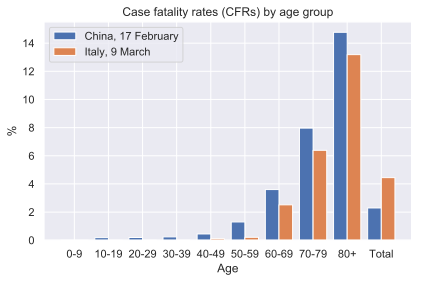

In [40]:
def autolabel(rects, ax, decimal_points=1, fontsize=10):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        text_offset = (0, 3) if height >= 0 else (-2, -13)
        ax.annotate(f"{height:.{decimal_points}f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=text_offset,
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=fontsize)

def bar_chart_by_age(datasets, type, show_numbers=True, size=None):
    n_data = len(datasets)
    w = 1/n_data
    if size is not None:
        fig, ax = plt.subplots(figsize=size)
    
    else:
        fig, ax = plt.subplots()
    
    ax.set_xlabel('Age')
    ax.set_ylabel('%')
    i = 0
    for data in datasets:
        data_id  = data.country + ', ' + data.date
        if type == 'cases_by_age':
            labels = datasets[0].age_ranges    
            x = 1.25 * np.arange(len(labels))  # the label locations
            x_init = x - 0.5 + w/2
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.set_title('Proportion of confirmed cases by age group')
            y = 100 * data.case_rates_by_age
            bar = ax.bar(x_init + i/n_data, y, w, label=data_id)
    
        elif type == 'cfr':
            labels = datasets[0].age_ranges + ['Total']  
            x = 1.25 * np.arange(len(labels))  # the label locations
            x_init = x - 0.5 + w/2
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.set_ylabel('%')
            ax.set_title('Case fatality rates (CFRs) by age group')
            y = np.append(100*data.cfr, 100*data.total_cfr)
            bar = ax.bar(x_init + i/n_data, y, w, label=data_id)
        
        else:
            raise NotImplementedError
            print("Plot type not supported. Please choose between 'cases_by_age' and 'cfr'.")
        
        i += 1
        if show_numbers:
            autolabel(bar, ax)

    ax.legend()
    fig.tight_layout()
    plt.show()
    return fig


data_Simpson = [China_Feb17, Italy_Mar9]
fig = bar_chart_by_age(data_Simpson, 'cfr', show_numbers=False)
fig.savefig('ChinaItalyCFRs.pdf', transparent=True, bbox_inches='tight')

This looks like a paradigmatic example of *Simpson's paradox*, which  refers  to  the  observation  that  aggregating data across subpopulations (here: age groups) may lead to opposite conclusions from considering the different subpopulations separately.

**Proportion of confirmed cases by age group**

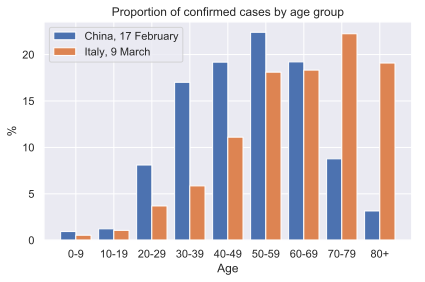

In [41]:
fig = bar_chart_by_age(data_Simpson, 'cases_by_age', show_numbers=False)
fig.savefig('ChinaItalyCaseDemographic.pdf', transparent=True, bbox_inches='tight')

As can be seen, the case demographic differs significantly between the two countries, i.e. there is a statistical association between the country and the proportion of confirmed cases per age group. 

This difference in the proportion of cases per age group is not apparent from or reflected in the age-specific CFRs from the previous figure, but explains the source of this instance of Simpson's paradox.

# 3) A causal model for Covid-19 CFR data



To better understand the (perhaps somewhat confusing) reversal pattern presented in 2), we now take a coarse-grained causal modelling perspective, in order to reason about different (direct and indirect) causal effects of country on mortality.

## 3.1) Assumptions

We consider the following variables,


*   Country $C\in \{China, Italy, ...\}$,
*   Age-group $A\in\{\text{0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80+}\}$,
*   Mortality or medical outcome $M\in\{0,1\}$, with $M=1$ indicating death,

and assume the following causal relationships between them:

*  $C\rightarrow A$
*  $C\rightarrow M$
*  $A\rightarrow M$

In particular, note that, within this view, age $A$ is a *mediator* between country $C$ and mortality $M$.

In addition, all following calculations rest on the (admittedly strong) assumption of no hidden confounding to enable causal and counterfactual reasoning based on the available observational data.

# 4) Total, direct, and indirect (age-mediated) causal effects on mortality


Given the above assumptions about how the variables country $C$, age $A$, and mortality $M$ are causally related, we can now start to answer causal queries.

In the following, we review definitions of different causal effects and us them to anser different questions about Covid-19 CFR data.

## Total causal effect (TCE)



We start with the total causal effect (TCE) which describes the expected change in outcome under a change in treatment. 

---

**Definition.** The TCE of a treatment $T$ on an outcome $Y$ is defined as

$$TCE_{0\rightarrow 1} = \mathbb{E}[Y|do(T=1)] - \mathbb{E}[Y|do(T=0)].$$

---


In our case, we may be interested in the TCE of country on mortality, i.e., the question

> *``What would be the expected change in mortality (as measured by the total CFR) if the country were changed from China to Italy?''*

which can be answered by computing

$$TCE_{\text{China}\rightarrow\text{Italy}} = \mathbb{E}[M|do(C=\text{Italy})] - \mathbb{E}[M|do(C=\text{China})].$$

Since we assume causal sufficiency to overcome the lack of experimental data, this takes the form:

$$TCE_{\text{China}\rightarrow\text{Italy}} = \sum_a P_{A|C}(a|\text{Italy}) P_{M|A,C}(1|a,\text{Italy}) - P_{A|C}(a|\text{China}) P_{M|A,C}(1|a, \text{China})$$

which corresponds to the difference in total CFRs.

In [42]:
def total_causal_effect(baseline, treatment):
  return treatment.total_cfr - baseline.total_cfr

print('Total CFR for China:', China_Feb17.total_cfr)
print('Total CFR for Italy:', Italy_Mar9.total_cfr)
print('TCE_China-->Italy = ',
      100 * total_causal_effect(China_Feb17, Italy_Mar9),
      '%')

Total CFR for China: 0.02290025071633238
Total CFR for Italy: 0.04448043857463244
TCE_China-->Italy =  2.158018785830006 %


This means that (subject to our assumptions), changing country from China to Italy would lead to an increase of 2.15% in overall CFR.

However, this does not tell us much about where this difference stems from. Instead, we may want to ask how much of the change in total CFR is due to the differences in case demographic noted earlier, and what proportion can be attributed to other country-specific factors. 
(Recall that within our view the TCE comprises both a direct effect of country on mortality, and an indirect effect mediated by age.) In other words, we want to better understand the role played by the mediating variable age.
We therefore now turn to the field of causal mediation analysis, which is concerned with quantifying such direct and indirect effects.

## Controlled direct effect (CDE)

First, we consider the controlled direct effect (CDE), which measures how much an outcome changes if the treatment is changed while keeping the mediator fixed at a given level.

---
**Definition.** The CDE of a treatment $T$ on an outcome $Y$ in presence of a mediator $X$ fixed at $x$ is given by

$$\text{CDE}_{0\rightarrow 1}(x)=\mathbb{E}\left[Y|do(T=1, X=x)\right]-\mathbb{E}\left[Y|do(T=0, X=x))\right].$$

---
In our case, we may want to reason about the CDE within a particular age group (e.g., 50-59 year olds), i.e., the question

> *``For 50--59 year-olds, is it safer to get the disease in China or in Italy?''*

which can be answered by computing

$$\text{CDE}_{\text{China}\rightarrow\text{Italy}}(a)=\mathbb{E}\left[M|do(C=\text{Italy}, A=a)\right]-\mathbb{E}\left[M|do(C=\text{China}, A=a)\right]$$

Given our assumptions, this reduces to

$$\text{CDE}_{\text{China}\rightarrow\text{Italy}}(a)= P_{M|A,C}(1|\text{Italy}, a)-P_{M|A,C}(1|\text{China}, a)$$

which corresponds to the difference of age-specific CFRs.


In [43]:
def controlled_direct_effect(baseline, treatment, age_group_index):
    return treatment.cfr[age_group_index] - baseline.cfr[age_group_index]

print('CDE_China-->Italy(50-59) =',
      100 * controlled_direct_effect(China_Feb17, Italy_Mar9, 6),
      '%')

CDE_China-->Italy(50-59) = -1.0848440940556217 %


This means that for that age group it would be safer in Italy with a lower age-specific CFR of ~1.1%.

## Natural direct effect (NDE)


As there are many CDEs (one for each age group), seeking a population-level measure we next turn to the natural direct effect (NDE) which captures how much the outcome would change if the treatment were changed while the mediator kept behaving as it would under the baseline or control.

---
**Definition.** The NDE of a treatment $T$ on an outcome $Y$ in presence of a mediator $X$ is given by 

$$\text{NDE}_{0\rightarrow 1}=\mathbb{E}\left[Y_{X_0}|do(T=1)\right]-\mathbb{E}\left[Y_{X_0}|do(T=0)\right].$$
 
where the subscript notation indicates the counterfactual outcome.

---


In our case, we may want to reason about the NDE of changing country from China to Italy, i.e., the question

> *“For the Chinese case demographic, would the Italian approach have been better?”*

which can be answered by computing

$$\text{NDE}_{\text{China}\rightarrow\text{Italy}}=\mathbb{E}\left[M_{A_\text{China}}|do(C=\text{Italy})\right]-\mathbb{E}\left[M_{A_\text{China}}|do(C=\text{China})\right]$$

Here, it takes the form:

$$\text{NDE}_{\text{China}\rightarrow\text{Italy}}= \sum_{a} P_{A|C}(a|\text{China})\left[P_{M|A,C}(1|\text{Italy}, a)-P_{M|A,C}(1|\text{China}, a)\right]$$ 


In [44]:
def natural_direct_effect(baseline, treatment):
    return sum(baseline.case_rates_by_age * (treatment.cfr - baseline.cfr))

print('NDE_China --> Italy =', 100 * natural_direct_effect(China_Feb17, Italy_Mar9), '%')

NDE_China --> Italy = -0.763238369493364 %


This suggests that when accounting for the case demographic, the Italian approach initially (i.e., on 9 March) resulted in lower CFR than *the Chinese approach*. 

## Natural indirect effect (NIE)

Finally, we turn to quantifying the indirect age-mediated effect using the notion of the natural indirect effect (NIE), which measures how much the outcome would change if the treatment were kept constant while the mediator behaved as it would under a change in treatment. 

---

**Definition.** The NIE of a treatment $T$ on an outcome $Y$ in presence of a mediator $X$ is given by the expression:

$$\text{NIE}_{0\rightarrow1}=\mathbb{E}[Y_{X_1}|do(T=0)]-\mathbb{E}[Y_{X_0}|do(T=0)].$$

---

In our case, we may want to reason about the NIE of changing country from China to Italy, i.e., the question

> *“How would the overallCFRin China change if the case demographic had instead been that186from Italy, while keeping all else (i.e., theCFR’s of each age group) the same?”*

which can be answered by computing

$$\text{NIE}_{\text{China}\rightarrow\text{Italy}}=\mathbb{E}[M_{A=A_\text{Italy}}|do(C=\text{China})]-\mathbb{E}[M_{A=A_\text{China}}|do(C=\text{China})].$$

Given our assumptions, this takes the form

$$\text{NIE}_{\text{China}\rightarrow\text{Italy}}= \sum_{a} \left[P_{A|C}(a|\text{Italy})- P_{A|C}(a|\text{China})\right] P_{M|A,C}(1|\text{China}, a)$$ 


In [45]:
def natural_indirect_effect(baseline, treatment):
    return sum((treatment.case_rates_by_age - baseline.case_rates_by_age) * baseline.cfr)

print('NIE_China --> Italy =', 100 * natural_indirect_effect(China_Feb17, Italy_Mar9), '%')

NIE_China --> Italy = 3.2679727670571466 %


This means that only changing the case demographic from the Chinese one to that in Italy (while keeping all else the same) would lead to an increase in total CFR of ~3.3%.

# 5)  Case study: mediation analysis of age-related effects on Covid-19 CFRs 

## Tracing causal effects over time
While we have so far only considered the situation in Italy at the beginning of March, we now show the temporal evolution of TCE, NDE, and NIE of changing country from China to Italy over a period of ~11 weeks until end of May.

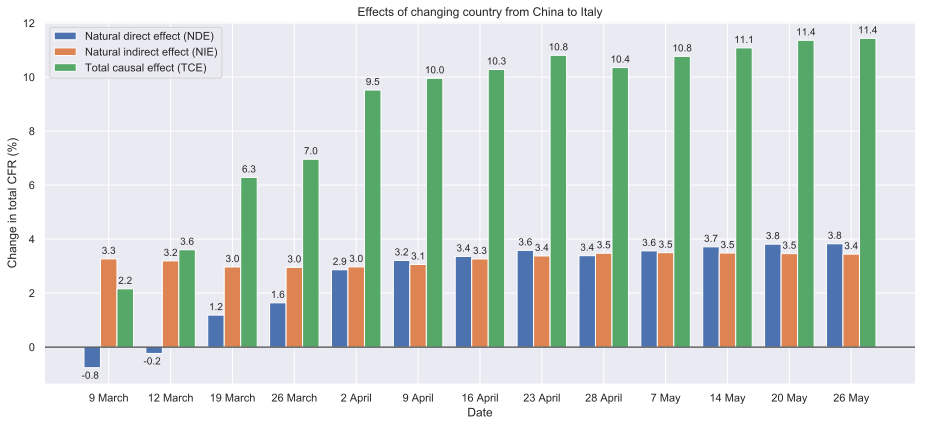

In [46]:
def show_causal_effects_over_time(baseline, treatments, show_numbers=True, size=None):
    n_treatments = len(treatments)
    assert n_treatments > 0 and baseline is not None
    tc = treatments[0].country
    x = 1.25 * np.arange(n_treatments)
    w = 1/3
    x_init = x - 0.5 + w/2
    if size is not None:
        fig, ax = plt.subplots(figsize=size)
    
    else:
        fig, ax = plt.subplots()
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Change in total CFR (%)')
    ax.set_xticks(x)
    ax.set_title('Effects of changing country from '+baseline.country+' to '+tc)
    i = 0
    TCEs = []
    NDEs = []
    NIEs = []
    labels = []
    for treatment in treatments:
        assert treatment.country == tc
        TCEs.append(100 * total_causal_effect(baseline, treatment))
        NDEs.append(100 * natural_direct_effect(baseline, treatment))
        NIEs.append(100 * natural_indirect_effect(baseline, treatment))
        labels.append(treatment.date)

    bar1 = ax.bar(x_init, NDEs, w, label='Natural direct effect (NDE)')
    bar2 = ax.bar(x_init + w, NIEs, w, label='Natural indirect effect (NIE)')
    bar3 = ax.bar(x_init + 2 * w, TCEs, w, label=('Total causal effect (TCE)'))
    if show_numbers:
        autolabel(bar1, ax)
        autolabel(bar2, ax)
        autolabel(bar3, ax)

    ax.set_xticklabels(labels)
    plt.axhline(y=0,linewidth=1, color='k')
    ax.legend()
    fig.tight_layout()
    plt.show()
    return fig


temporal_data_Italy = [Italy_Mar9, Italy_Mar12, Italy_Mar19, Italy_Mar26, 
                       Italy_Apr2, Italy_Apr9, Italy_Apr16, Italy_Apr23, Italy_Apr28,
                       Italy_May7, Italy_May14, Italy_May20, Italy_May26]              

fig = show_causal_effects_over_time(China_Feb17, temporal_data_Italy, size=(13,6))
fig.savefig('ChinaItalyEffectsOverTime.pdf', transparent=True, bbox_inches='tight')

## Comparison between several different countries

Next, we compare NDE and NIE across several different countries in our dataset.

Data from Argentina contains 14675 cases and 507 fatalities (CFR=3.5), reported on 28 May
Data from China contains 44672 cases and 1023 fatalities (CFR=2.3), reported on 17 February
Data from Colombia contains 25366 cases and 822 fatalities (CFR=3.2), reported on 28 May
Data from Diam. Princ. contains 619 cases and 7 fatalities (CFR=1.1), reported on 26 March
Data from Italy contains 230760 cases and 31676 fatalities (CFR=13.7), reported on 26 May
Data from Netherlands contains 45947 cases and 5903 fatalities (CFR=12.8), reported on 28 May
Data from Portugal contains 31596 cases and 1369 fatalities (CFR=4.3), reported on 28 May
Data from South Africa contains 27280 cases and 577 fatalities (CFR=2.1), reported on 28 May
Data from Spain contains 258760 cases and 20585 fatalities (CFR=8.0), reported on 29 May
Data from Sweden contains 34432 cases and 4125 fatalities (CFR=12.0), reported on 18 May
Data from Switzerland contains 30707 cases and 1648 fatalities (CFR=5.4), reported on 26 May


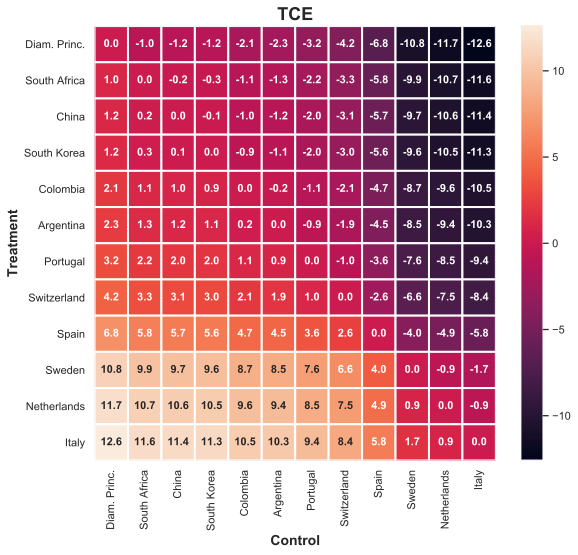

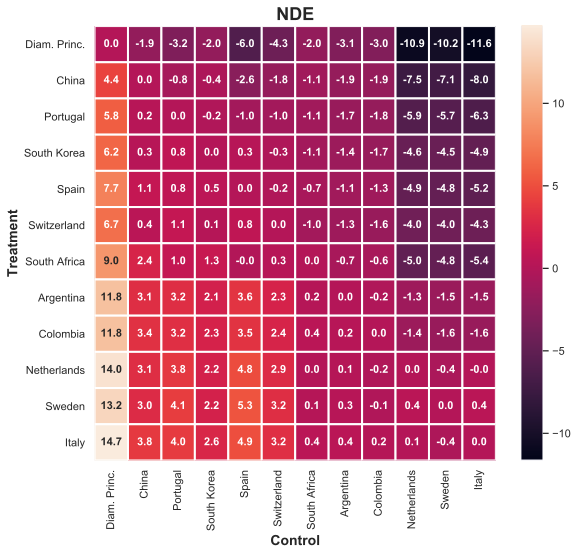

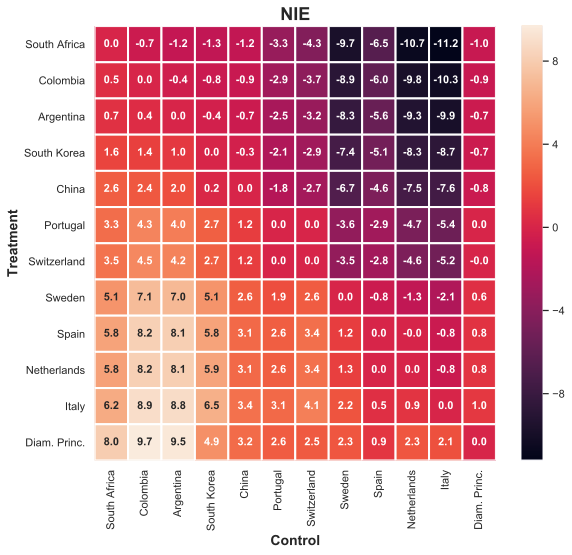

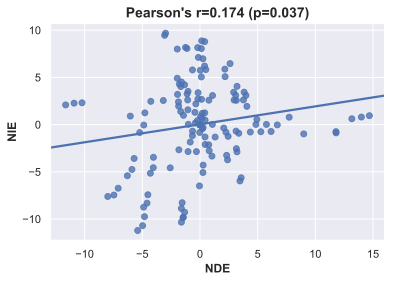

In [47]:
def plot_effect_matrix(A, names, effect_type, add_title=True, size=8):
    f, ax = plt.subplots(figsize=(size+1, size))
    ax = sns.heatmap(100*A, annot=True, fmt=".1f", linewidths=2, annot_kws={"size": 11, "weight":'bold'}, xticklabels=names, yticklabels=names)
    ax.set_ylabel('Treatment', fontsize=14, fontweight='bold')
    ax.set_xlabel('Control', fontsize=14, fontweight='bold')
    if add_title:
        ax.set_title(effect_type, fontsize=18, fontweight='bold')
    
    f.savefig((effect_type+'.pdf'),bbox_inches='tight')
    return f

def sort_effect_matrix_by_row_mean(A, country_names):
    row_means = np.array([np.mean(A[i]) for i in range(A.shape[0])])
    sorted_indices = row_means.argsort()
    sorted_country_names = [country_names[i] for i in sorted_indices]
    B = A[sorted_indices,:]
    C = B[:, sorted_indices]
    return C, sorted_country_names

def plot_NIE_vs_NDE(NDEs, NIEs):
    f, ax = plt.subplots()
    ax = sns.regplot(100*NDEs, 100*NIEs, ci=None)
    ax.set_xlabel('NDE', fontsize=12, fontweight='bold')
    ax.set_ylabel('NIE', fontsize=12, fontweight='bold')
    R, p = stats.pearsonr(NDEs, NIEs)
    title = ("Pearson's r=%.3f (p=%.3f)" %(R, p))
    ax.set_title(title, fontsize=14, fontweight='bold')
    f.savefig('NIE_vs_NDE.pdf', bbox_inches='tight')
    return f

latest_data_different_countries = [
                                   Argentina_May28,
                                   China_Feb17,  
                                   Colombia_May28,
                                   DiamondPrincess_Mar26,
                                   Italy_May26,
                                   Netherlands_28May,
                                   Portugal_28May,
                                   SouthAfrica_28May,
                                   Spain_May29,  
                                   Sweden_May18,
                                   Switzerland_May26,
                                   SouthKorea_May25
                                   ]

n_countries = len(latest_data_different_countries)
n_cases = 0
n_fatalities = 0 
country_names = []
TCEs = np.zeros((n_countries, n_countries))
NDEs = np.zeros((n_countries, n_countries))
NIEs = np.zeros((n_countries, n_countries))
for i in range(n_countries):
    # treatment country
    country1 = latest_data_different_countries[i]
    n_cases += country1.total_cases
    n_fatalities += country1.total_fatalities
    country_names.append(country1.country)
    print('Data from %s contains %d cases and %d fatalities (CFR=%.1f), reported on %s'
    %(country1.country, country1.total_cases, country1.total_fatalities, 100*country1.total_cfr, country1.date))
    for j in range(n_countries):
        # control/baseline country
        country2 = latest_data_different_countries[j]
        TCEs[i, j] = total_causal_effect(country2, country1)
        NDEs[i, j] = natural_direct_effect(country2, country1)
        NIEs[i, j] = natural_indirect_effect(country2, country1)

print('Analysed data from...')
print(n_countries, ' countries,')
print('involving ...')
print(n_cases, ' cases,')
print('and ...')
print(n_fatalities, ' fatalities.')
print('Total cumulative CFR across all countries is: ')
print(n_fatalities/n_cases)

print('NDE and NIE have opposite sign for...')
n_reversals = 0
for i in range(n_countries):
    for j in range(n_countries):
        if (NDEs[i,j]<0 and NIEs[i,j]>0) or (NDEs[i,j]>0 and NIEs[i,j]<0):
            n_reversals += 1

print(n_reversals, ' pairs of countries')


# sort effect matrices by average treatment effect and plot them in that order
TCEs_ordered, TCE_country_names_ordered = sort_effect_matrix_by_row_mean(TCEs, country_names)
NDEs_ordered, NDE_country_names_ordered = sort_effect_matrix_by_row_mean(NDEs, country_names)
NIEs_ordered, NIE_country_names_ordered = sort_effect_matrix_by_row_mean(NIEs, country_names)

f_TCE_ordered = plot_effect_matrix(TCEs_ordered, TCE_country_names_ordered, effect_type='TCE')
f_NDE_ordered = plot_effect_matrix(NDEs_ordered, NDE_country_names_ordered, effect_type='NDE')
f_NIE_ordered = plot_effect_matrix(NIEs_ordered, NIE_country_names_ordered, effect_type='NIE')


# scatter plot of NIE vs NDE with Pearson correlation
flattened_NDEs = NDEs.reshape(n_countries*n_countries)
flattened_NIEs = NIEs.reshape(n_countries*n_countries)
f_NIE_VS_NDE = plot_NIE_vs_NDE(flattened_NDEs, flattened_NIEs)


# investigate correlations between ranking in terms of NIE with median age and median case demographic
# the following data was used for median ages and ranking according to it
# data are listed as:  Country_rank_median-age (0 means oldest population) 
#              Argentina_9_31.7,
#              China_8_37.4,
#              Colombia_10_30.0
#              DiamondPrincess_0_58,  # mean instead of median
#              Italy_1_45.5,
#              Netherlands_3_42.6,
#              Portugal_5_42.2,
#              SouthAfrica_11_27.1,
#              Spain_2_42.7,
#              Sweden_7_41.2,
#              Switzerland_4_42.4,
#              SouthKorea_6_41.8

# order in which countries are listed: [ARG, CHI, COL, DP, IT, NETH, POR, SA, SPA, SWE, SWITZ, SK]
population_age_median_ranks = np.array([9, 8, 10, 0, 1, 3, 5, 11, 2, 7, 4, 6])  # 0 means oldest population
NIE_ranks = np.array([9, 7, 10, 0, 1, 2, 6, 11, 3, 4, 5, 8])  # 0 means highest average NIE when country is used as treatment
NDE_ranks = np.array([4, 10, 3, 11, 0, 2, 9, 5, 7, 1, 6, 8])  # 0 means highest average NDE when country is used as treatment

r_s, p_s = stats.spearmanr(population_age_median_ranks, NIE_ranks)
print('Spearman correlation between rank by median age and rank by average NIE:', r_s, p_s)
r, p = stats.spearmanr(NDE_ranks, NIE_ranks)
print('Spearman correlation between rank by NDE and rank by NIE:', r, p)
print('Differences in ranking by NDE and NIE:', NDE_ranks-NIE_ranks)

# Additional findings and figures

## Expected CDE for comparing different strategies from the perspective of a third country

As an example application, taking an expectation of the CDE with respect to a given age distribution, we can compare the effectiveness of the Chinese and Italian *approaches* in case they were to be applied within a third country with a different age distribution, say Spain:


$$\mathbb{E}_{P(A|C=\text{Spain})}\left[\text{CDE}_{\text{China}\rightarrow\text{Italy}}(A)\right]=\sum_{a} P(A=a|C=\text{Spain}) \, \text{CDE}_{\text{China}\rightarrow\text{Italy}}(a)$$

In [48]:
def expected_controlled_direct_effect(baseline, treatment, control):
    return sum(control.case_rates_by_age * (treatment.cfr - baseline.cfr))

print('Expected CDE_China-->Italy(A_Spain)', 100 * expected_controlled_direct_effect(China_Feb17, Italy_Mar9, Spain_May29), '%')

Expected CDE_China-->Italy(A_Spain) -1.013150416162912 %


This means that for the Spanish case demographic, the Italian approach (at the beginning of March) would have been preferable to the Chinese one. 

## Relationship between TCE, NDE, and NIE: moderation and empirical confirmation of the substractivity principle

We now empirically confirm the substractivity principle and refute the wrong assumption that TCE may in general be decomposed into a sum of NDE and NIE. To do so, we use the longitudinal data from Italy as an example.

In [49]:
for data in temporal_data_Italy:
    TCE = total_causal_effect(China_Feb17, data)
    NDE = natural_direct_effect(China_Feb17, data)
    inv_NDE = natural_direct_effect(data, China_Feb17)
    NIE = natural_indirect_effect(China_Feb17, data)
    inv_NIE = natural_indirect_effect(data, China_Feb17)
    print('TCE - (NDE - inv_NIE) =', np.round(100 * (TCE - (NDE - inv_NIE)), 12))
    print('TCE - (NIE - inv_NDE) =', np.round(100 * (TCE - (NIE - inv_NDE)), 12))

TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = 0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = 0.0
TCE - (NDE - inv_NIE) = 0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0
TCE - (NDE - inv_NIE) = -0.0
TCE - (NIE - inv_NDE) = -0.0


The difference is always zero (up to machine precision), empirically confirming the substractivity principle of mediation analysis:


$$\text{TCE}_{0\rightarrow1} = \text{NDE}_{0\rightarrow1} - \text{NIE}_{1\rightarrow0}=\text{NIE}_{0\rightarrow1} - \text{NDE}_{1\rightarrow0}$$

In [50]:
for data in temporal_data_Italy:
    TCE = total_causal_effect(China_Feb17, data)
    NDE = natural_direct_effect(baseline=China_Feb17, treatment=data)
    NIE = natural_indirect_effect(baseline=China_Feb17, treatment=data)
    print('TCE - (NDE + NIE) = ', 100 * (TCE - (NDE + NIE)))

TCE - (NDE + NIE) =  -0.34671561173377635
TCE - (NDE + NIE) =  0.6462639182052708
TCE - (NDE + NIE) =  2.1335707780289064
TCE - (NDE + NIE) =  2.365780158436438
TCE - (NDE + NIE) =  3.687017149040054
TCE - (NDE + NIE) =  3.6859287315227944
TCE - (NDE + NIE) =  3.6600174535703673
TCE - (NDE + NIE) =  3.8493193737276346
TCE - (NDE + NIE) =  3.49244380915316
TCE - (NDE + NIE) =  3.710147195198861
TCE - (NDE + NIE) =  3.884898783375977
TCE - (NDE + NIE) =  4.088728421367745
TCE - (NDE + NIE) =  4.166153807923307


Conversely, NDE and NIE do not add up to the TCE, indicating that there is some level of moderation or interaction involved.

$$\text{TCE}_{0\rightarrow 1} \neq \text{NDE}_{0\rightarrow 1} + \text{NIE}_{0\rightarrow 1}$$


## Italy: temporal evolution of CFRs and case-demographic

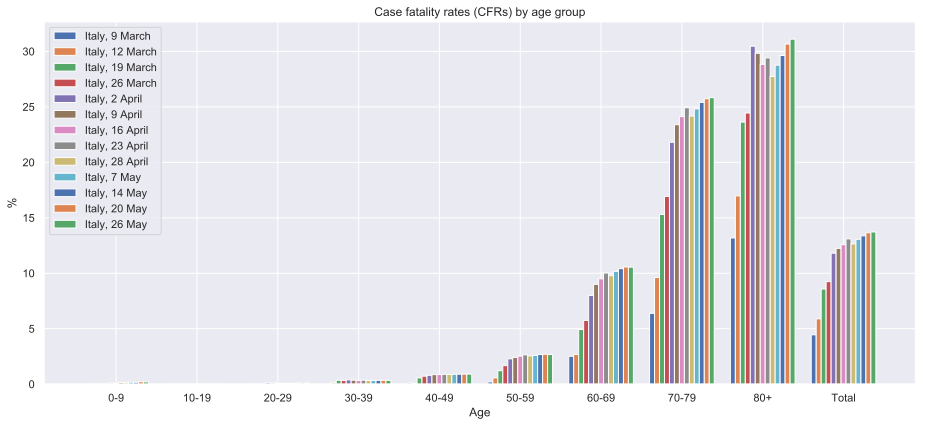

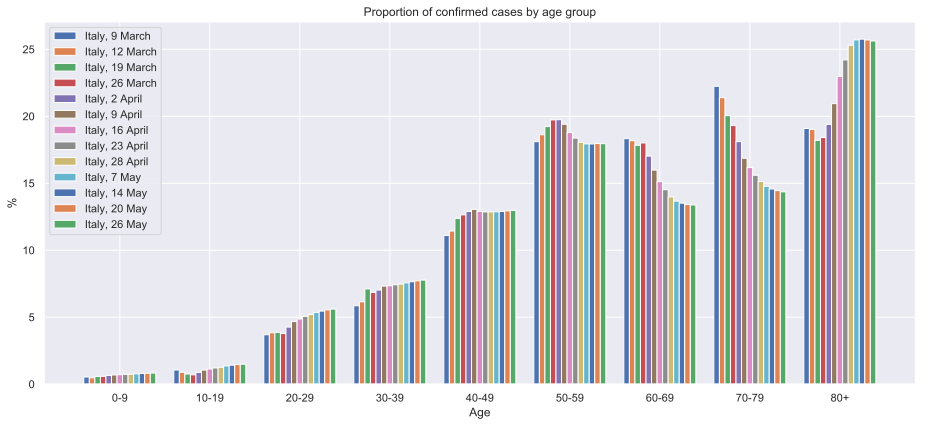

In [51]:
fig = bar_chart_by_age(temporal_data_Italy, 'cfr', show_numbers=False, size=(13,6))
fig.savefig('ItalyCFRsEvolution.pdf', transparent=True, bbox_inches='tight')

fig = bar_chart_by_age(temporal_data_Italy, 'cases_by_age', show_numbers=False, size=(13,6))
fig.savefig('ItalyCaseDemographicEvolution.pdf', transparent=True, bbox_inches='tight')

## China vs Italy: differences between case demographic and population demographic

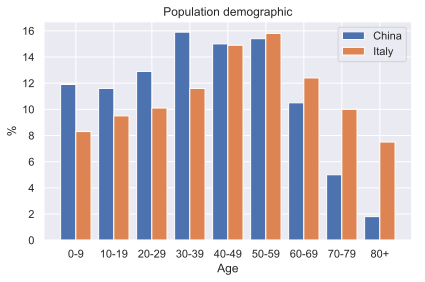

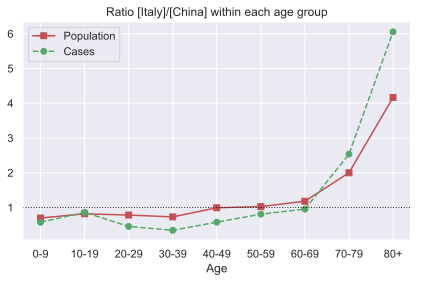

In [52]:
labels = China_Feb17.age_ranges

x = 1.25 * np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('%')
ax.set_title('Population demographic')
y_Ch = [11.9, 11.6, 12.9, 15.9, 15, 15.4, 10.5, 5, 1.8]
ax.bar(x - 1/4, y_Ch, 1/2, label='China')
y_It = [8.3, 9.5, 10.1, 11.6, 14.9, 15.8, 12.4, 10, 7.5]
ax.bar(x + 1/4, y_It, 1/2, label='Italy')
ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('ChinaItalyPopulationDemographic.pdf', transparent=True, bbox_inches='tight')


x = 1 * np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
ax.set_xlabel('Age')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Ratio [Italy]/[China] within each age group')
ax.plot(np.array(y_It)/np.array(y_Ch), 'rs-', label='Population')
ax.plot(np.array(Italy_Mar9.case_rates_by_age)/np.array(China_Feb17.case_rates_by_age), 'go--', label='Cases')
plt.axhline(y=1, linewidth=1, color='k', ls=':')
ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('ChinaItalyRatios.pdf', bbox_inches='tight')

## Spain: temporal evolution of CFRs and case demographic

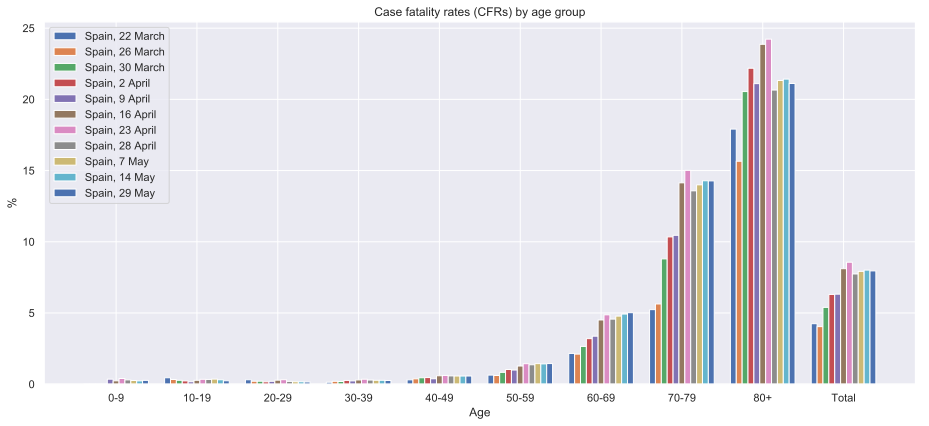

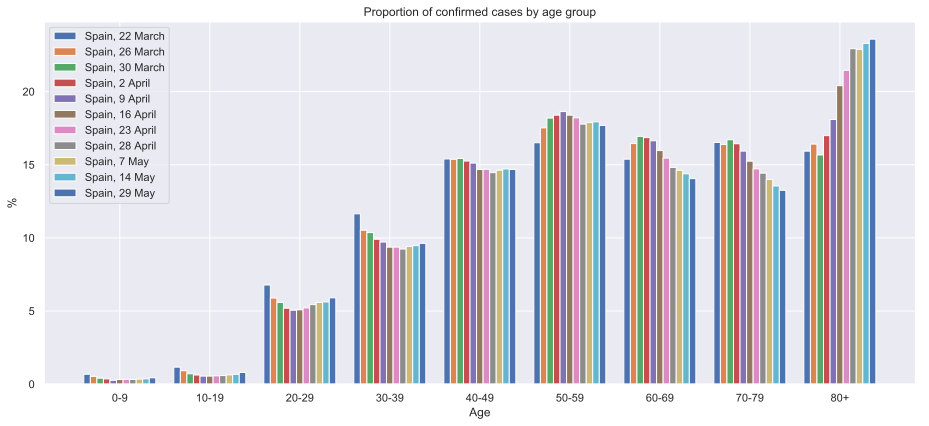

In [53]:
temporal_data_Spain = [Spain_Mar22, Spain_Mar26, Spain_Mar30,
                       Spain_Apr2, Spain_Apr9, Spain_Apr16, Spain_Apr23, Spain_Apr28,
                       Spain_May7, Spain_May14, Spain_May29] 

fig = bar_chart_by_age(temporal_data_Spain, 'cfr', show_numbers=False, size=(13,6))
fig.savefig('SpainCFRsEvolution.pdf', transparent=True, bbox_inches='tight')

fig = bar_chart_by_age(temporal_data_Spain, 'cases_by_age', show_numbers=False, size=(13,6))
fig.savefig('SpainCaseDemographicEvolution.pdf', transparent=True, bbox_inches='tight')

## Spain: tracing causal effects over time
Below we show a plot of the temporal evoluation of TCE, NDE, and NIE over time for changing country from China to Spain (instead of Italy as shown in the main paper).


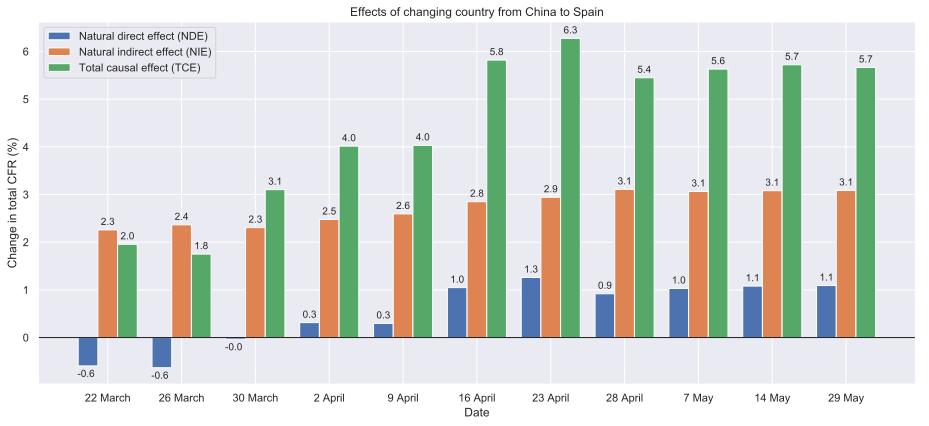

In [54]:
fig = show_causal_effects_over_time(China_Feb17, temporal_data_Spain, size=(13,6))
fig.savefig('ChinaSpainEffectsOverTime.pdf', transparent=True, bbox_inches='tight')

## Comparing latest CFRs by age group and case demographic for different countries

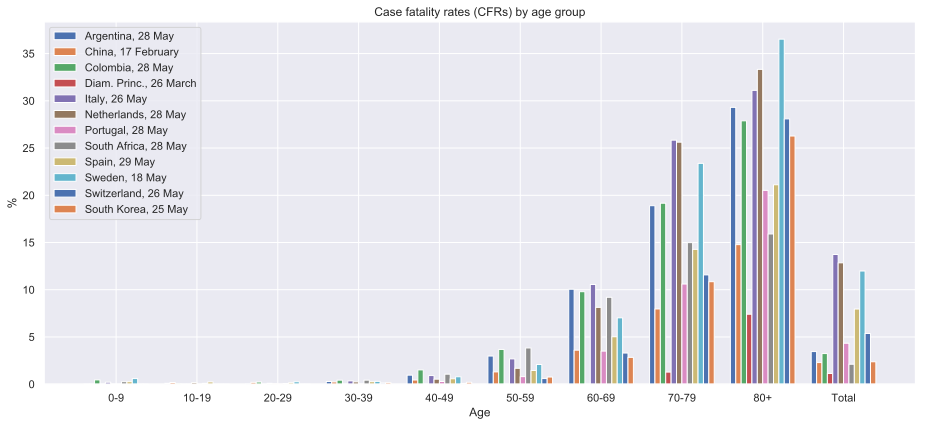

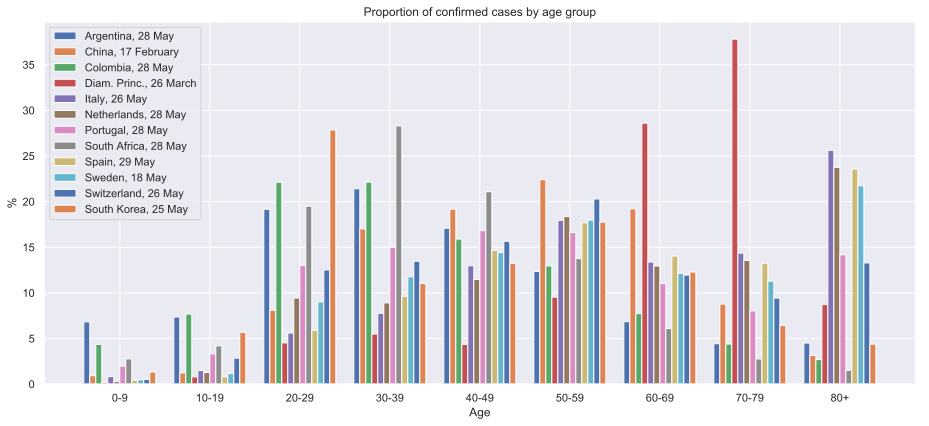

In [55]:
fig = bar_chart_by_age(latest_data_different_countries, 'cfr', show_numbers=False, size=(13,6))
fig.savefig('DifferentCountriesCFRsEvolution.pdf', transparent=True, bbox_inches='tight')

fig = bar_chart_by_age(latest_data_different_countries, 'cases_by_age', show_numbers=False, size=(13,6))
fig.savefig('DifferentCountriesCaseDemographicEvolution.pdf', transparent=True, bbox_inches='tight')

# Exporting datasets to make them easily available to the public

In [56]:
column_names = ['Country', 'Date of reporting', 'Age group', 'Confirmed cases', 'Confirmed fatalities']
data = []
for c in latest_data_different_countries:
    for i in range(len(c.age_ranges)):
        data.append([c.country,
                     c.date+'2020',
                     c.age_ranges[i],
                     c.confirmed_cases[i],
                     c.fatalities[i]
                     ])

df_latest = pd.DataFrame(data, columns=column_names)

print(df_latest)

df_latest.to_csv('Covid-19_age-stratified_dataset_for_different_countries.csv')
df_latest.to_excel('Covid-19_age-stratified_dataset_for_different_countries.xlsx')
df_latest.to_pickle('Covid-19_age-stratified_dataset_for_different_countries.pkl')
df_latest.to_json('Covid-19_age-stratified_dataset_for_different_countries.json')

          Country Date of reporting Age group  Confirmed cases  \
0       Argentina        28 May2020       0-9             1002   
1       Argentina        28 May2020     10-19             1080   
2       Argentina        28 May2020     20-29             2813   
3       Argentina        28 May2020     30-39             3142   
4       Argentina        28 May2020     40-49             2508   
5       Argentina        28 May2020     50-59             1812   
6       Argentina        28 May2020     60-69             1005   
7       Argentina        28 May2020     70-79              651   
8       Argentina        28 May2020       80+              662   
9           China   17 February2020       0-9              416   
10          China   17 February2020     10-19              549   
11          China   17 February2020     20-29             3619   
12          China   17 February2020     30-39             7600   
13          China   17 February2020     40-49             8571   
14        

In [57]:
column_names = ['Country', 'Date of reporting', 'Age group', 'Confirmed cases', 'Confirmed fatalities']
data = []
for c in temporal_data_Italy:
    for i in range(len(c.age_ranges)):
        data.append([c.country,
                     c.date+'2020',
                     c.age_ranges[i],
                     c.confirmed_cases[i],
                     c.fatalities[i]
                     ])

df_Italy_temporal = pd.DataFrame(data, columns=column_names)

print(df_Italy_temporal)

df_Italy_temporal.to_csv('Covid-19_age-stratified_dataset_for_Italy_at_different_points_in_time.csv')
df_Italy_temporal.to_excel('Covid-19_age-stratified_dataset_for_Italy_at_different_points_in_time.xlsx')
df_Italy_temporal.to_pickle('Covid-19_age-stratified_dataset_for_Italy_at_different_points_in_time.pkl')
df_Italy_temporal.to_json('Covid-19_age-stratified_dataset_for_Italy_at_different_points_in_time.json')

    Country Date of reporting Age group  Confirmed cases  Confirmed fatalities
0     Italy       9 March2020       0-9               43                     0
1     Italy       9 March2020     10-19               85                     0
2     Italy       9 March2020     20-29              296                     0
3     Italy       9 March2020     30-39              470                     0
4     Italy       9 March2020     40-49              891                     1
5     Italy       9 March2020     50-59             1453                     3
6     Italy       9 March2020     60-69             1471                    37
7     Italy       9 March2020     70-79             1785                   114
8     Italy       9 March2020       80+             1532                   202
9     Italy      12 March2020       0-9               63                     0
10    Italy      12 March2020     10-19              118                     0
11    Italy      12 March2020     20-29             

In [58]:
column_names = ['Country', 'Date of reporting', 'Age group', 'Confirmed cases', 'Confirmed fatalities']
data = []
for c in temporal_data_Spain:
    for i in range(len(c.age_ranges)):
        data.append([c.country,
                     c.date+'2020',
                     c.age_ranges[i],
                     c.confirmed_cases[i],
                     c.fatalities[i]
                     ])

df_Spain_temporal = pd.DataFrame(data, columns=column_names)

print(df_Spain_temporal)

df_Spain_temporal.to_csv('Covid-19_age-stratified_dataset_for_Spain_at_different_points_in_time.csv')
df_Spain_temporal.to_excel('Covid-19_age-stratified_dataset_for_Spain_at_different_points_in_time.xlsx')
df_Spain_temporal.to_pickle('Covid-19_age-stratified_dataset_for_Spain_at_different_points_in_time.pkl')
df_Spain_temporal.to_json('Covid-19_age-stratified_dataset_for_Spain_at_different_points_in_time.json')

   Country Date of reporting Age group  Confirmed cases  Confirmed fatalities
0    Spain      22 March2020       0-9              129                     0
1    Spain      22 March2020     10-19              221                     1
2    Spain      22 March2020     20-29             1285                     4
3    Spain      22 March2020     30-39             2208                     3
4    Spain      22 March2020     40-49             2919                     9
5    Spain      22 March2020     50-59             3129                    20
6    Spain      22 March2020     60-69             2916                    63
7    Spain      22 March2020     70-79             3132                   164
8    Spain      22 March2020       80+             3020                   541
9    Spain      26 March2020       0-9              175                     0
10   Spain      26 March2020     10-19              302                     1
11   Spain      26 March2020     20-29             1932         